In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import optuna
import os

In [2]:
train = pd.read_csv("../data/train.csv")
predict = pd.read_csv("../data/test.csv")

# データの前処理

### Object型のデータのラベル付け

In [7]:
# Label Encoding

def label_encode(df, columns):
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

encode_columns = ['road_type','lighting','weather','time_of_day']
train = label_encode(train, encode_columns)
predict = label_encode(predict, encode_columns)


In [9]:
# bool型の変換

def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    for col in bool_columns:
        df[col] = df[col].astype(int)
    return df

train = bool_to_int(train)
predict = bool_to_int(predict)

In [10]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,2,2,0.06,35,0,2,0,1,0,0,1,1,0.13
1,1,2,4,0.99,35,0,0,1,0,1,1,1,0,0.35
2,2,1,4,0.63,70,1,0,0,1,2,1,0,2,0.30
3,3,0,4,0.07,35,1,2,1,1,2,0,0,1,0.21
4,4,1,1,0.58,60,0,1,0,0,1,1,0,1,0.56


### データ分割

In [32]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(columns=['id','accident_risk'])
    y = df['accident_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)

predict_X = predict.copy()
predict_X = predict_X.drop(columns=['id'])

# モデルの学習

In [14]:
# XGBoostモデルの構築
def build_xgboost_model(n_estimators=100,max_depth=5,learning_rate=0.1,radom_state=42):
    model = xgb.XGBRegressor(
        # 回帰タスクに適した損失関数(RMSE)
        obextive = 'reg:squarederror',
        # 決定機の数
        n_estimators = n_estimators,
        # 決定木の深さ
        max_depth = max_depth,
        # 学習率
        learning_rate = learning_rate,
        # 乱数シード
        random_state = radom_state
    )
    return model

# モデルの構築
xgb_model = build_xgboost_model()

/Users/yasuo/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "obextive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


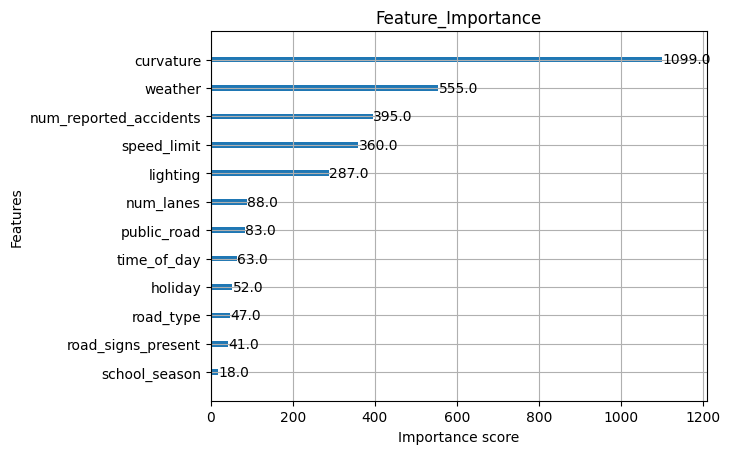

In [16]:
# 特徴量のプロット

xgb_model.fit(X_train, y_train)

xgb.plot_importance(xgb_model)
plt.title('Feature_Importance')
plt.show()

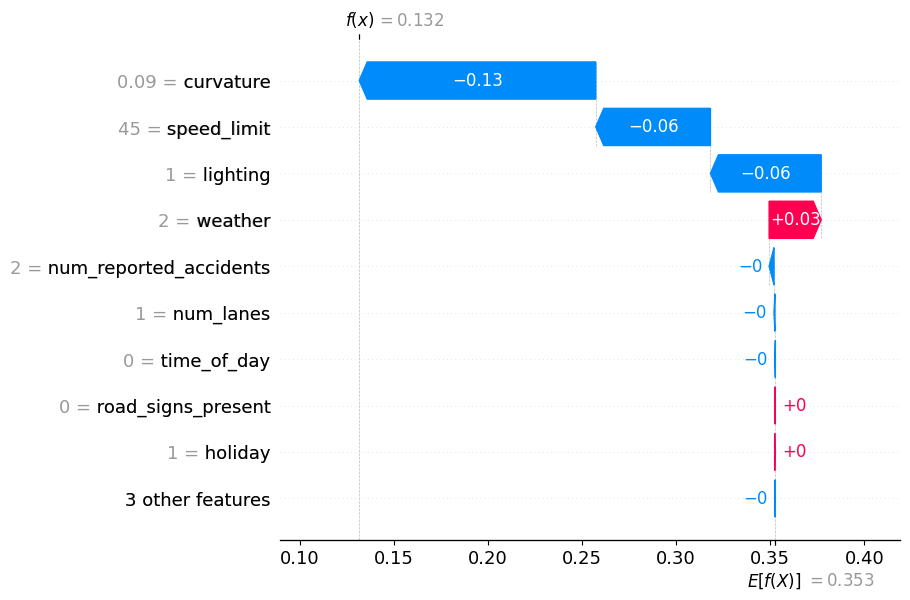

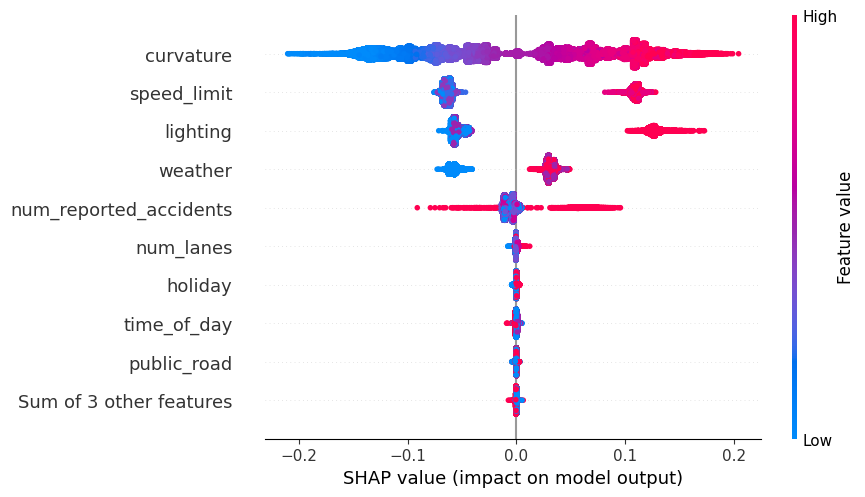

In [24]:
def explain_model(model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    shap.plots.waterfall(shap_values[0])

    shap.plots.beeswarm(shap_values)

explain_model(xgb_model)

# モデルの評価

In [20]:
# テストデータの予測
xgb_pred = xgb_model.predict(X_test)

In [21]:
def evalute_metrics(y_true,y_pred):
    results = []

    def calulate_metrics(y_true,y_pred):
        mse = mean_squared_error(y_true,y_pred)
        mae = mean_absolute_error(y_true,y_pred)
        r2 = r2_score(y_true,y_pred)
        return {
            'MSE':mse,
            'RMSE':mae,
            'R2':r2
        }

    results.append(calulate_metrics(y_true,y_pred))
    
    return pd.DataFrame(results)

# 評価指標の計算
results = evalute_metrics(y_test,xgb_pred)
display(results)

,MSE,RMSE,R2
0,0.003185,0.043834,0.884641


# 最適化学習

In [26]:
def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # 決定木の数
        'max_depth': trial.suggest_int('max_depth', 3, 10), # 決定木の深さ
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # 学習率
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # サブサンプル
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # 列のサブサンプル
        'gamma': trial.suggest_float('gamma', 0, 1), # 葉ノードを分割するために必要な最小損失削減
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # 葉ノードの重みの最小合計
        'objective': 'reg:squarederror', # 回帰タスクに適した損失関数
        'random_state': 42                
    }

    model = xgb.XGBRegressor(**params)
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(optimize_xgboost, n_trials=50)

# dislay best results
print('Best trial:')
trial = study.best_trial # 最良のトライアル
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Predict
optimized_xgb = xgb.XGBRegressor(**trial.params, random_state=42)
optimized_xgb.fit(X_train, y_train)

[I 2025-10-16 14:42:23,214] A new study created in memory with name: no-name-8e4957a0-51e3-49b6-8cec-b1dd9bc62825
[I 2025-10-16 14:42:23,663] Trial 0 finished with value: 0.0032345504182350426 and parameters: {'n_estimators': 144, 'max_depth': 6, 'learning_rate': 0.28104148380149635, 'subsample': 0.7255220447412846, 'colsample_bytree': 0.7844568098146504, 'gamma': 0.5676752085495615, 'min_child_weight': 8}. Best is trial 0 with value: 0.0032345504182350426.
[I 2025-10-16 14:42:24,235] Trial 1 finished with value: 0.0032205183578251995 and parameters: {'n_estimators': 180, 'max_depth': 6, 'learning_rate': 0.11602470644756248, 'subsample': 0.6260943951375755, 'colsample_bytree': 0.9320677866033695, 'gamma': 0.44028103075815606, 'min_child_weight': 4}. Best is trial 1 with value: 0.0032205183578251995.
[I 2025-10-16 14:42:24,622] Trial 2 finished with value: 0.0032553407677720064 and parameters: {'n_estimators': 141, 'max_depth': 9, 'learning_rate': 0.1887083579265017, 'subsample': 0.6136

Best trial:
  MSE: 0.003165338020590731
  Params: 
    n_estimators: 292
    max_depth: 9
    learning_rate: 0.13349047783166818
    subsample: 0.9668668228769782
    colsample_bytree: 0.9342384747154492
    gamma: 0.05655864585813948
    min_child_weight: 4


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9342384747154492, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.05655864585813948, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.13349047783166818,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=292, n_jobs=None,
             num_parallel_tree=None, ...)

In [29]:
optimized_pred = optimized_xgb.predict(X_test)
optimized_metrics = evalute_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,RMSE,R2
0,0.003165,0.043659,0.885364


## 提出準備

In [35]:
# テストデータ予測
predict_y = optimized_xgb.predict(predict_X)
predict_df = pd.DataFrame(predict_y, columns=['accident_risk'])
submission = pd.concat([predict['id'], predict_df], axis=1)

display(submission.head())
print(submission.isnull().sum())

,id,accident_risk
0,517754,0.293073
1,517755,0.125899
2,517756,0.182832
3,517757,0.315844
4,517758,0.412264


id               0
accident_risk    0
dtype: int64


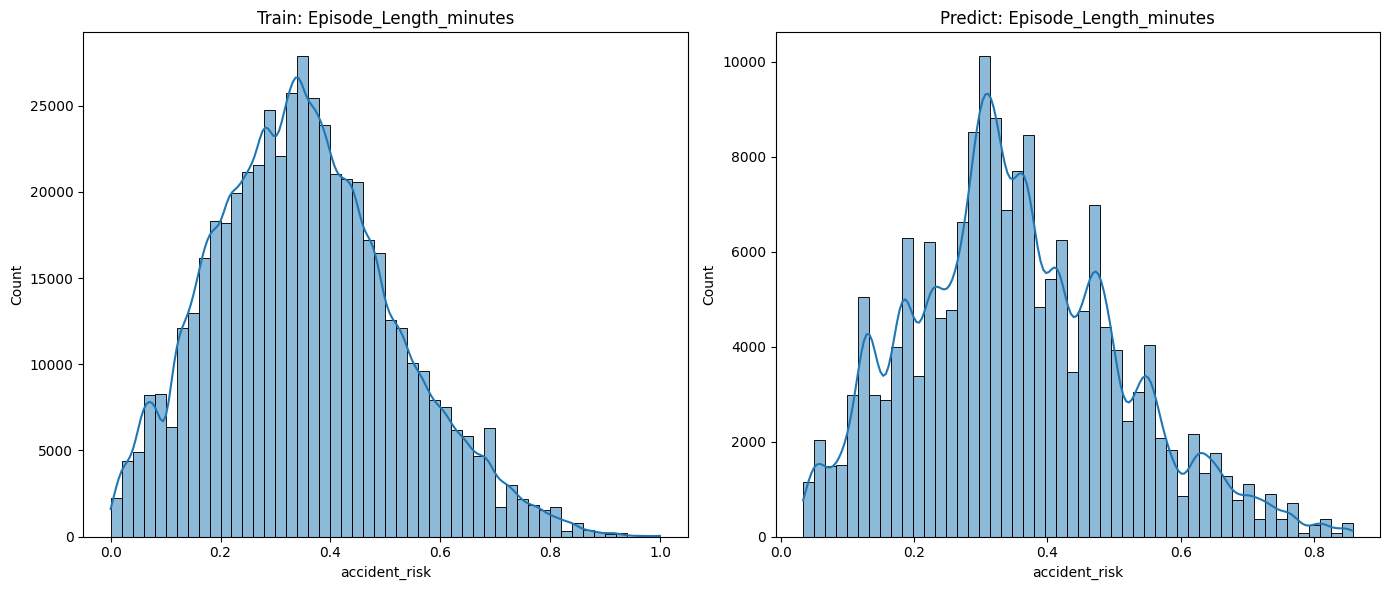

In [38]:
# サブプロットの準備（横に2つ）
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# train データのヒストグラム + KDE
sns.histplot(train['accident_risk'].dropna(), kde=True, bins=50, ax=axs[0])
axs[0].set_title('Train: Episode_Length_minutes')
#axs[0].set_xlabel('Episode_Length_minutes')

# predict データのヒストグラム + KDE
sns.histplot(submission['accident_risk'].dropna(), kde=True, bins=50, ax=axs[1])
axs[1].set_title('Predict: Episode_Length_minutes')
#axs[1].set_xlabel('Episode_Length_minutes')

# レイアウト調整して表示
plt.tight_layout()
plt.show()

In [44]:
file_path = '../submit/xgboost/xgboost_model_1.csv'

if os.path.exists(file_path):
     print(f"ファイルが既にあります{file_path}.")
else:
    submission.to_csv(file_path, index=False)
    print(f"ファイルを保存しました: {file_path}")

ファイルが既にあります../submit/xgboost/xgboost_model_1.csv.
